Importing Libraries:  
Python imports and modules that are required that are imported at the start:
-	os, sys, time, numpy (np alias), pandas (pd alias), matplotlib.pyplot (plt alias),  ipywidgets, tqdm.notebook, nibabel, glmsingle, bids, noise_ceiling, tc2see

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
from pprint import pprint
from pathlib import Path
from random import randint

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from tqdm.notebook import tqdm
import nibabel as nib
# import glmsingle
# from glmsingle.glmsingle import GLM_single
import bids
from bids import BIDSLayout
from scipy.ndimage import zoom, binary_dilation
import h5py
import nibabel as nib
from einops import rearrange

dir2 = os.path.abspath('..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)
    
from tc2see import load_data

from noise_ceiling import (
    compute_ncsnr,
    compute_nc,
)

Setting Paths and Variables:  
It sets up various directory paths for loading and saving data:
-	tc2see_version and subject are variables that specify the version of the dataset and the subject being analyzed.
-	tr is the repetition time (time between volume acquisitions in the fMRI data).

In [2]:
dataset_root = Path('E:\\fmri_processing\\results')
tc2see_version = 3 # [1, 2]
dataset_path = dataset_root
# dataset_path = dataset_root / f"TC2See_0{tc2see_version}"
derivatives_path = dataset_path / 'derivatives_TC2See'
# data_path = derivatives_path / 'spm'
data_path = derivatives_path / 'fmriprep'

Loading Data:  
The code loads fMRI data and associated information.
-	It loads a bold dataset, stimulus IDs, a brain mask, and an affine transformation matrix using the load_data function.
-	The loaded bold data represents the fMRI signal, and its shape is shown.

In [3]:
tr = 2 # 1.97
subject = 'sub-15'

bold, stimulus_ids, mask, affine = load_data(
    data_path / f'tc2see-v{tc2see_version}-bold-Copy.hdf5', 
    subject,
    tr_offset=6 / tr,
    run_normalize='linear_trend',
    interpolation=False,
    # run_ids=[2, 5],
)
bold.shape # num stimuli by num voxels

e:\Decoding\fmri-preprocessing\tc2see.py:66: RuntimeWarning: invalid value encountered in divide
  run_bold = (run_bold - predicted_bold) / group['bold_trend_std'][i]
e:\Decoding\fmri-preprocessing\tc2see.py:72: RuntimeWarning: Mean of empty slice
  bold = (bold - np.nanmean(bold, axis=0)) / np.nanstd(bold, axis=0)
c:\Users\James\anaconda3\envs\representationsLab\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(450, 127468)

Bounding Box Mask Function:  
This code create a function called bb_mask. This function creates a bounding box (3D region of interest) within the brain mask based on specified parameters.  
The code uses @interact to create an interactive visualization of the bounding box mask. This can have its parameters adjusted to visualize different regions within the brain.

In [4]:
def bb_mask(mask, vc_height_min, vc_height_max, vc_width, vc_depth): # bounding box mask
    brain_width, brain_depth, brain_height = mask.shape
    vc_center = np.array([brain_width//2, 0, 0])
    vc_bl = vc_center + np.array([-vc_width,0,vc_height_min]) # bottom left
    vc_tr = vc_center + np.array([vc_width,vc_depth,vc_height_max]) # top right
    vc_mask = np.zeros_like(mask)
    vc_mask[vc_bl[0]:vc_tr[0], vc_bl[1]:vc_tr[1], vc_bl[2]:vc_tr[2]] = True # boolean array
    return vc_mask[mask] # flattens both 3D arrays into a one dimensional vector (True values inside the bb, False values outside). Intersection of bb and brain


print(mask.shape)
brain_width, brain_depth, brain_height = mask.shape
@interact(vc_height_min=(0,brain_height), vc_height_max=(0,brain_height), vc_width=(0,brain_width//2), vc_depth=(0,brain_depth), show_height=(0,brain_height))
def show(vc_height_min, vc_height_max, vc_width, vc_depth, show_height):
    vc_center = np.array([brain_width//2, 0, 0])
    vc_bl = vc_center + np.array([-vc_width,0,vc_height_min])
    vc_tr = vc_center + np.array([vc_width,vc_depth,vc_height_max])
    vc_mask = np.zeros_like(mask)
    vc_mask[vc_bl[0]:vc_tr[0], vc_bl[1]:vc_tr[1], vc_bl[2]:vc_tr[2]] = 1

    vc_show = vc_mask.astype(int) + mask.astype(int)
    plt.figure(figsize=(12, 12))
    plt.imshow(vc_show[:, :, show_height], vmin=0., vmax=2,)

(67, 78, 63)


interactive(children=(IntSlider(value=31, description='vc_height_min', max=63), IntSlider(value=31, descriptio…

Model and Embedding Information & Loading Stimulus Representations:  
The code defines variables for the model name and embedding name. These refer to the neural network model and feature embeddings used for further analysis. The code loads stimulus embeddings from an HDF5 file and assigns it to the variable Y.

In [5]:
model_name = 'ViT-B=32'
embedding_name = 'embedding' # load the clip embeddings

with h5py.File(derivatives_path / f'{model_name}-features.hdf5', 'r') as f:
    stimulus = f[embedding_name][:]
Y = stimulus[stimulus_ids] # loads the stimulus representations to decode
# sets up a linear regression

Visualizing Stimulus Repetitions:  
The code visualizes stimulus repetitions by creating a binary matrix, where each element (i, j) represents whether stimulus i is the same as stimulus j.

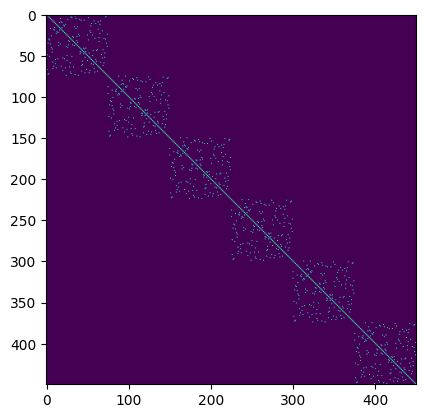

In [6]:
plt.imshow((stimulus_ids[None, :] == stimulus_ids[:, None])) # Shows where the repetitions of one image (comparing every stimulus id to every other stimulus id)
# Each row and columns corresponds to an image representation
# Ex. (1, 512), (512, 1)
# (512, 512)

Machine Learning Analysis:  
This code performs a machine learning analysis. It uses FracRidge for decoding the stimulus representations from the fMRI data. It splits the data into training and validation sets using K-fold cross-validation, it fits the model to the training data and predicts stimulus representations on the validation set, it computes distances between the predicted and actual stimulus representations, and it evaluates the accuracy of the model's predictions.  
Also performs a noise ceiling analysis, to assess the quality of the fMRI data. This analysis is performed for different runs and components.  
X represents the bold signal data obtained from fMRI scans, after applying selection criteria and data preprocessing.  
Y represents stimulus related data, which includes embeddings associated with the stimuli presented during the fMRI scans. It serves as the target data for the regression analysis, where the goal is to predict these stimuli related features based on the selected brain activity data in X.

In [7]:
from sklearn.model_selection import KFold
from fracridge import FracRidgeRegressorCV
from metrics import (
    cosine_distance, squared_euclidean_distance, r2_score, two_versus_two,
    two_versus_two_slow
)
import warnings

warnings.filterwarnings('ignore')
np.seterr(all="ignore")
#run_id_groups = [[[0, 3], [1, 4], [2, 5]]]
run_id_groups = [[2], [5]]
tr = 2 # 1.97
subjects = ['sub-15',]# 'sub-04']
model_name = 'ViT-B=32'
embedding_name = 'embedding'

for subject in subjects:
    print(f'{subject=}')
    
    for run_ids in run_id_groups:
        bold, stimulus_ids, mask, affine = load_data(
            data_path / f'tc2see-v{tc2see_version}-bold-test.hdf5', 
            subject,
            tr_offset=6 / tr,
            run_normalize='linear_trend',
            interpolation=False,
            run_ids=run_ids,
        )
        
        nc_file = f'noise_ceiling/{subject}/{subject}__run_ids_2__noise-ceiling.nii.gz'
        nc_series = nib.load(data_path / nc_file).get_fdata()

        component = 3 # 6s
        nc_volume = nc_series[..., component]
        nc_volume[:, :, :5] = 0.
        nc = nc_volume[mask]
        nc.shape
        nc_threshold = 30.
        print(f'{nc_threshold=}, num_voxels={(nc > nc_threshold).sum()}')
        X = bold[:, nc > nc_threshold]
        X_nan = np.isnan(X)
        X[X_nan] = 0.
        
        with h5py.File(derivatives_path / f'{model_name}-features.hdf5', 'r') as f:
            stimulus = f[embedding_name][:]
        Y = stimulus[stimulus_ids]

        folds = KFold(n_splits=5, shuffle=True, random_state=0)

        Y_pred = np.zeros_like(Y)
        for train_ids, val_ids in folds.split(X):
            X_train, Y_train = X[train_ids], Y[train_ids]
            X_val, Y_val = X[val_ids], Y[val_ids]

            model = FracRidgeRegressorCV()
            model.fit(X_train, Y_train)
            Y_pred[val_ids] = model.predict(X_val)

        distances = cosine_distance(torch.from_numpy(Y[None]).float(), torch.from_numpy(Y_pred[:, None]).float())
        accuracy = round(two_versus_two(distances, stimulus_ids=stimulus_ids).item() * 100, 2) 
        accuracy2 = round(two_versus_two_slow(distances, stimulus_ids=stimulus_ids) * 100, 2)

        print(f'{run_ids=}, {accuracy=}')

subject='sub-15'
nc_threshold=30.0, num_voxels=1236
run_ids=[2], accuracy=98.89
nc_threshold=30.0, num_voxels=1236
run_ids=[5], accuracy=81.44


Cosine Distance Analysis and two_versus_two Comparison:  
This code calculates cosine distances between two datasets, Y and Y_pred, and then performs a two_versus_two  analysis, comparing the dissimilarity of data points in the stimulus_ids.

In [8]:
distances = cosine_distance(torch.from_numpy(Y[None]).float(), torch.from_numpy(Y_pred[:, None]).float())
print(two_versus_two(distances, stimulus_ids=stimulus_ids))

tensor(0.8144)


Canonical Ordering of stimulus_ids:  
This code sorts the indices of stimulus_ids in ascending order and stores them in canonical_ordering_ids.

In [9]:
canonical_ordering_ids = np.argsort(stimulus_ids)

Cosine Distance Visualization for X_canonical:  
This code reorders and calculates cosine distances between stimuli in the matrix X. It visualizes these distances in a large image for analysis.

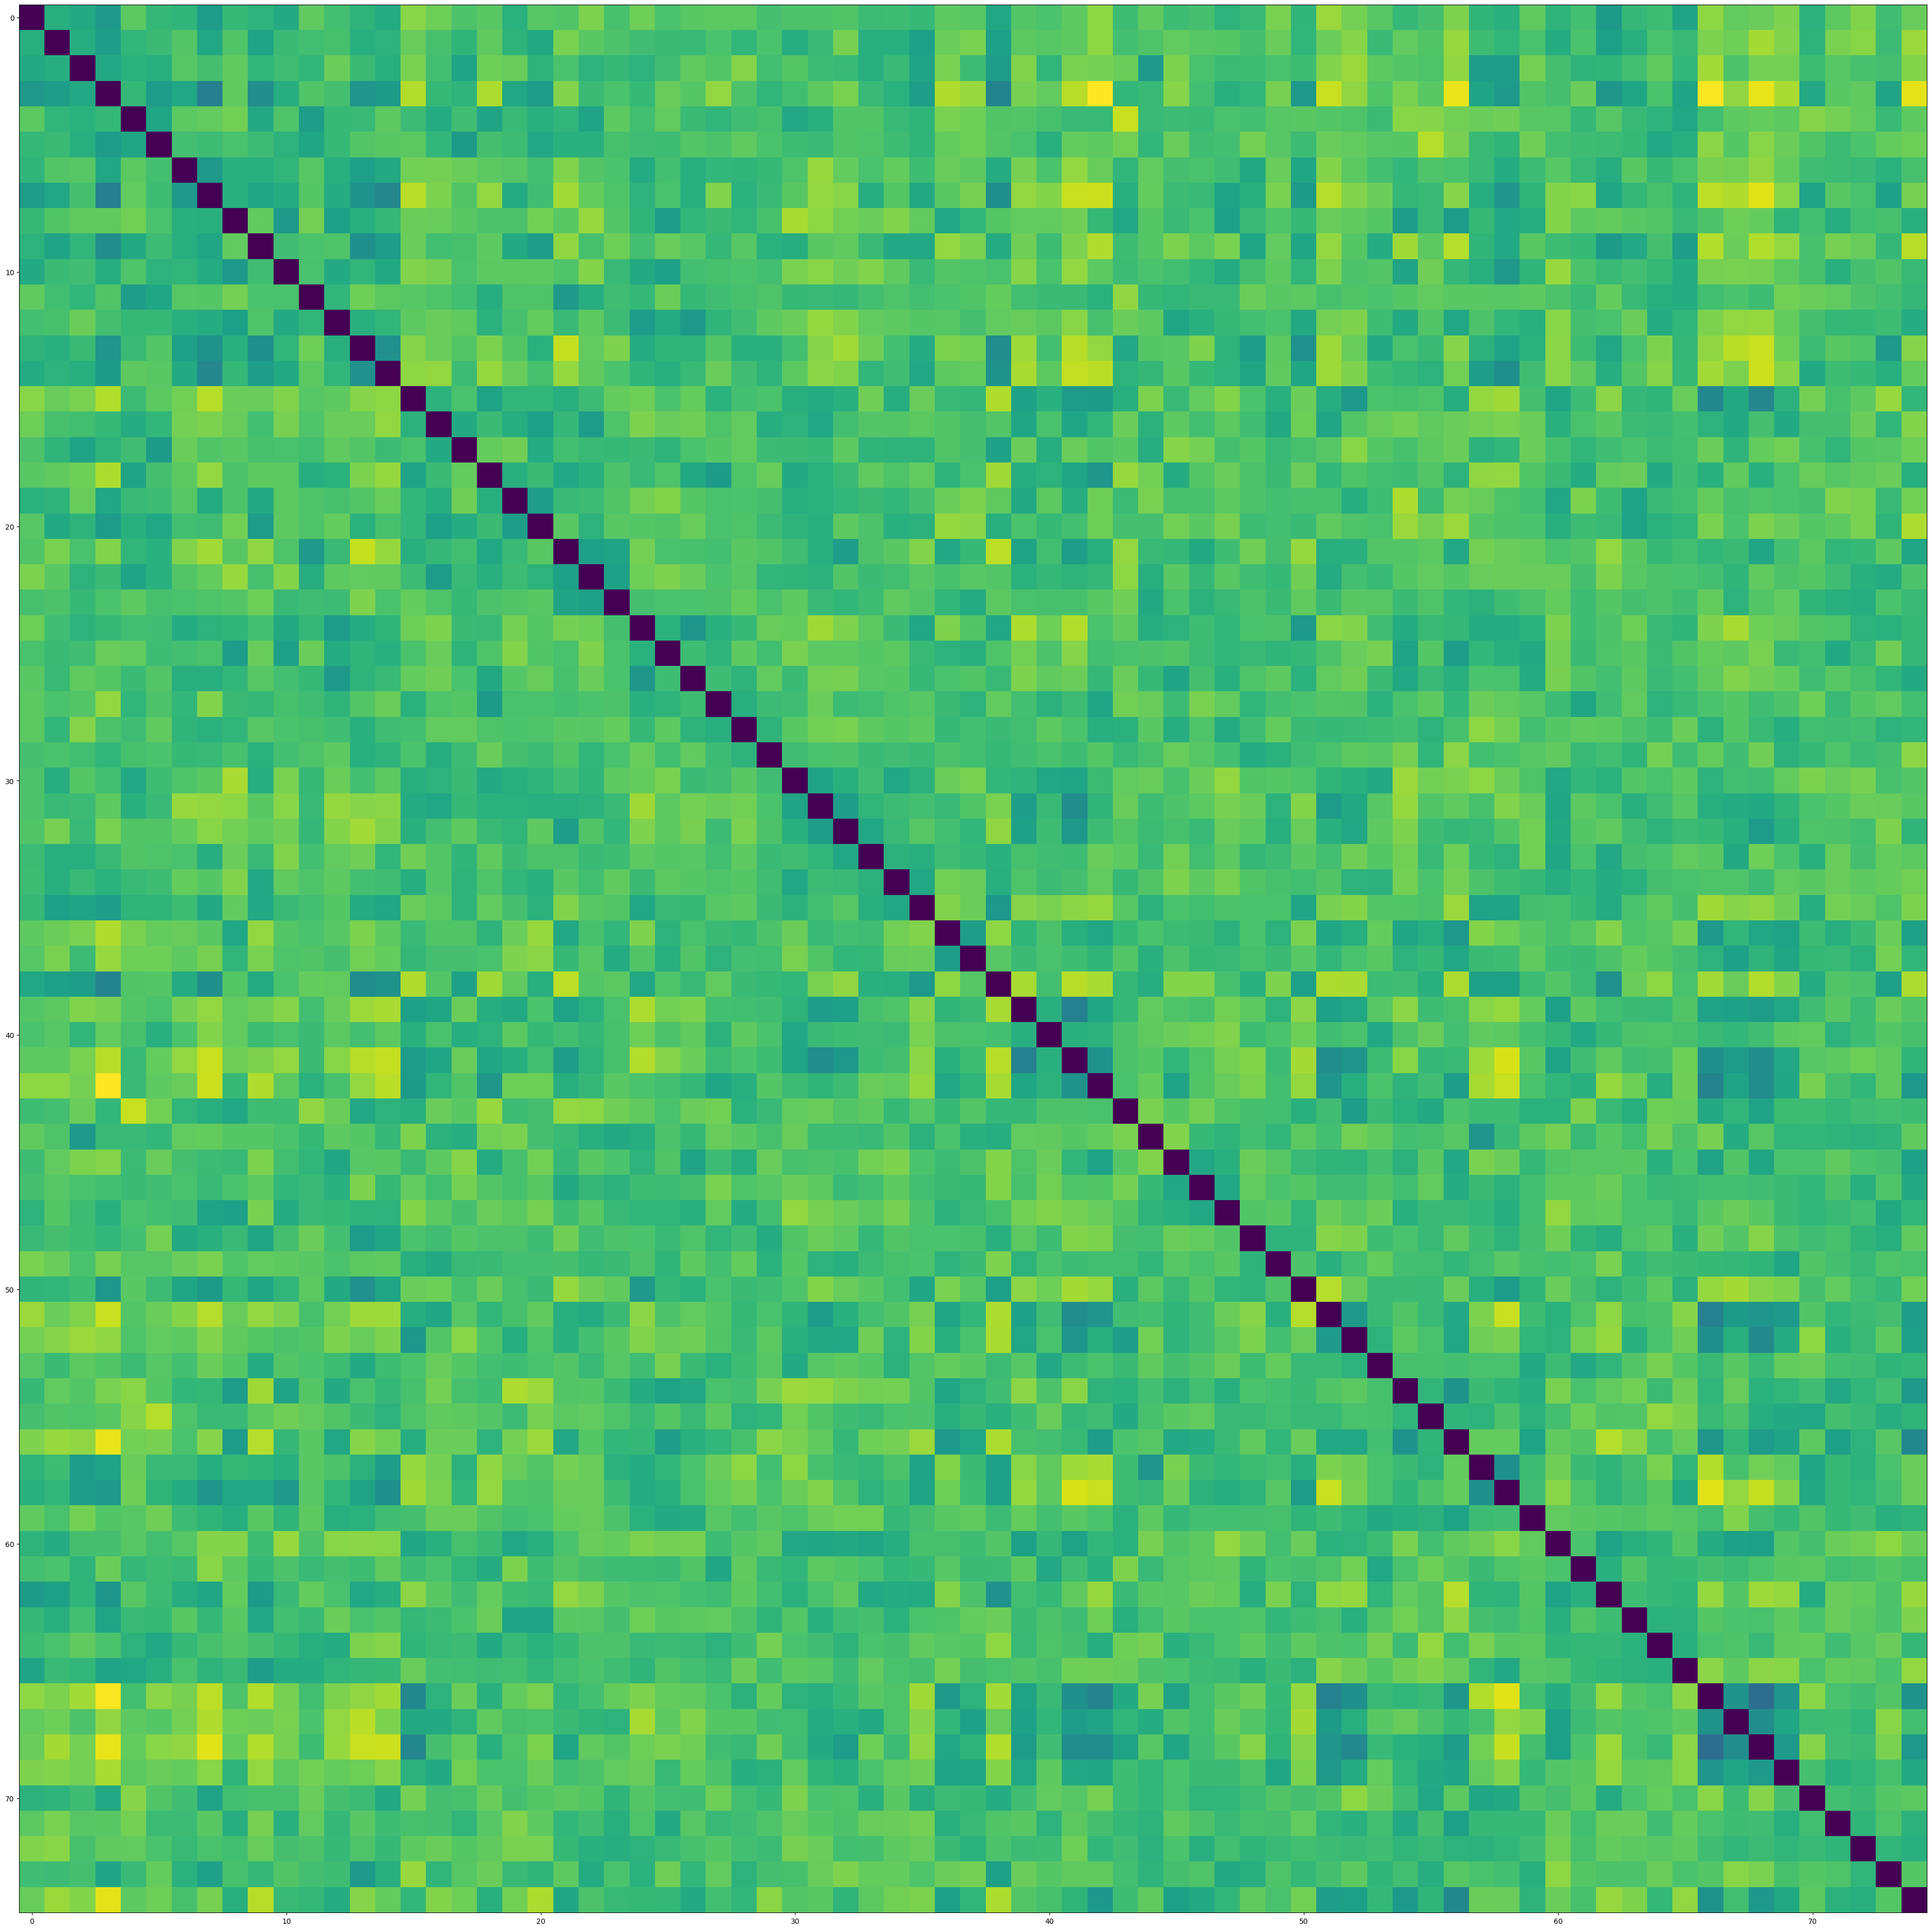

In [10]:
X_canonical = X[canonical_ordering_ids]
X_rsm = cosine_distance(torch.from_numpy(X_canonical[None]).float(), torch.from_numpy(X_canonical[:, None]).float())
plt.figure(figsize=(48, 48))
plt.imshow(X_rsm)

Cosine Distance Visualization for Y_canonical:  
This code reorders and calculates cosine distances between stimuli in the matrix Y. It visualizes these distances in a large image for analysis.

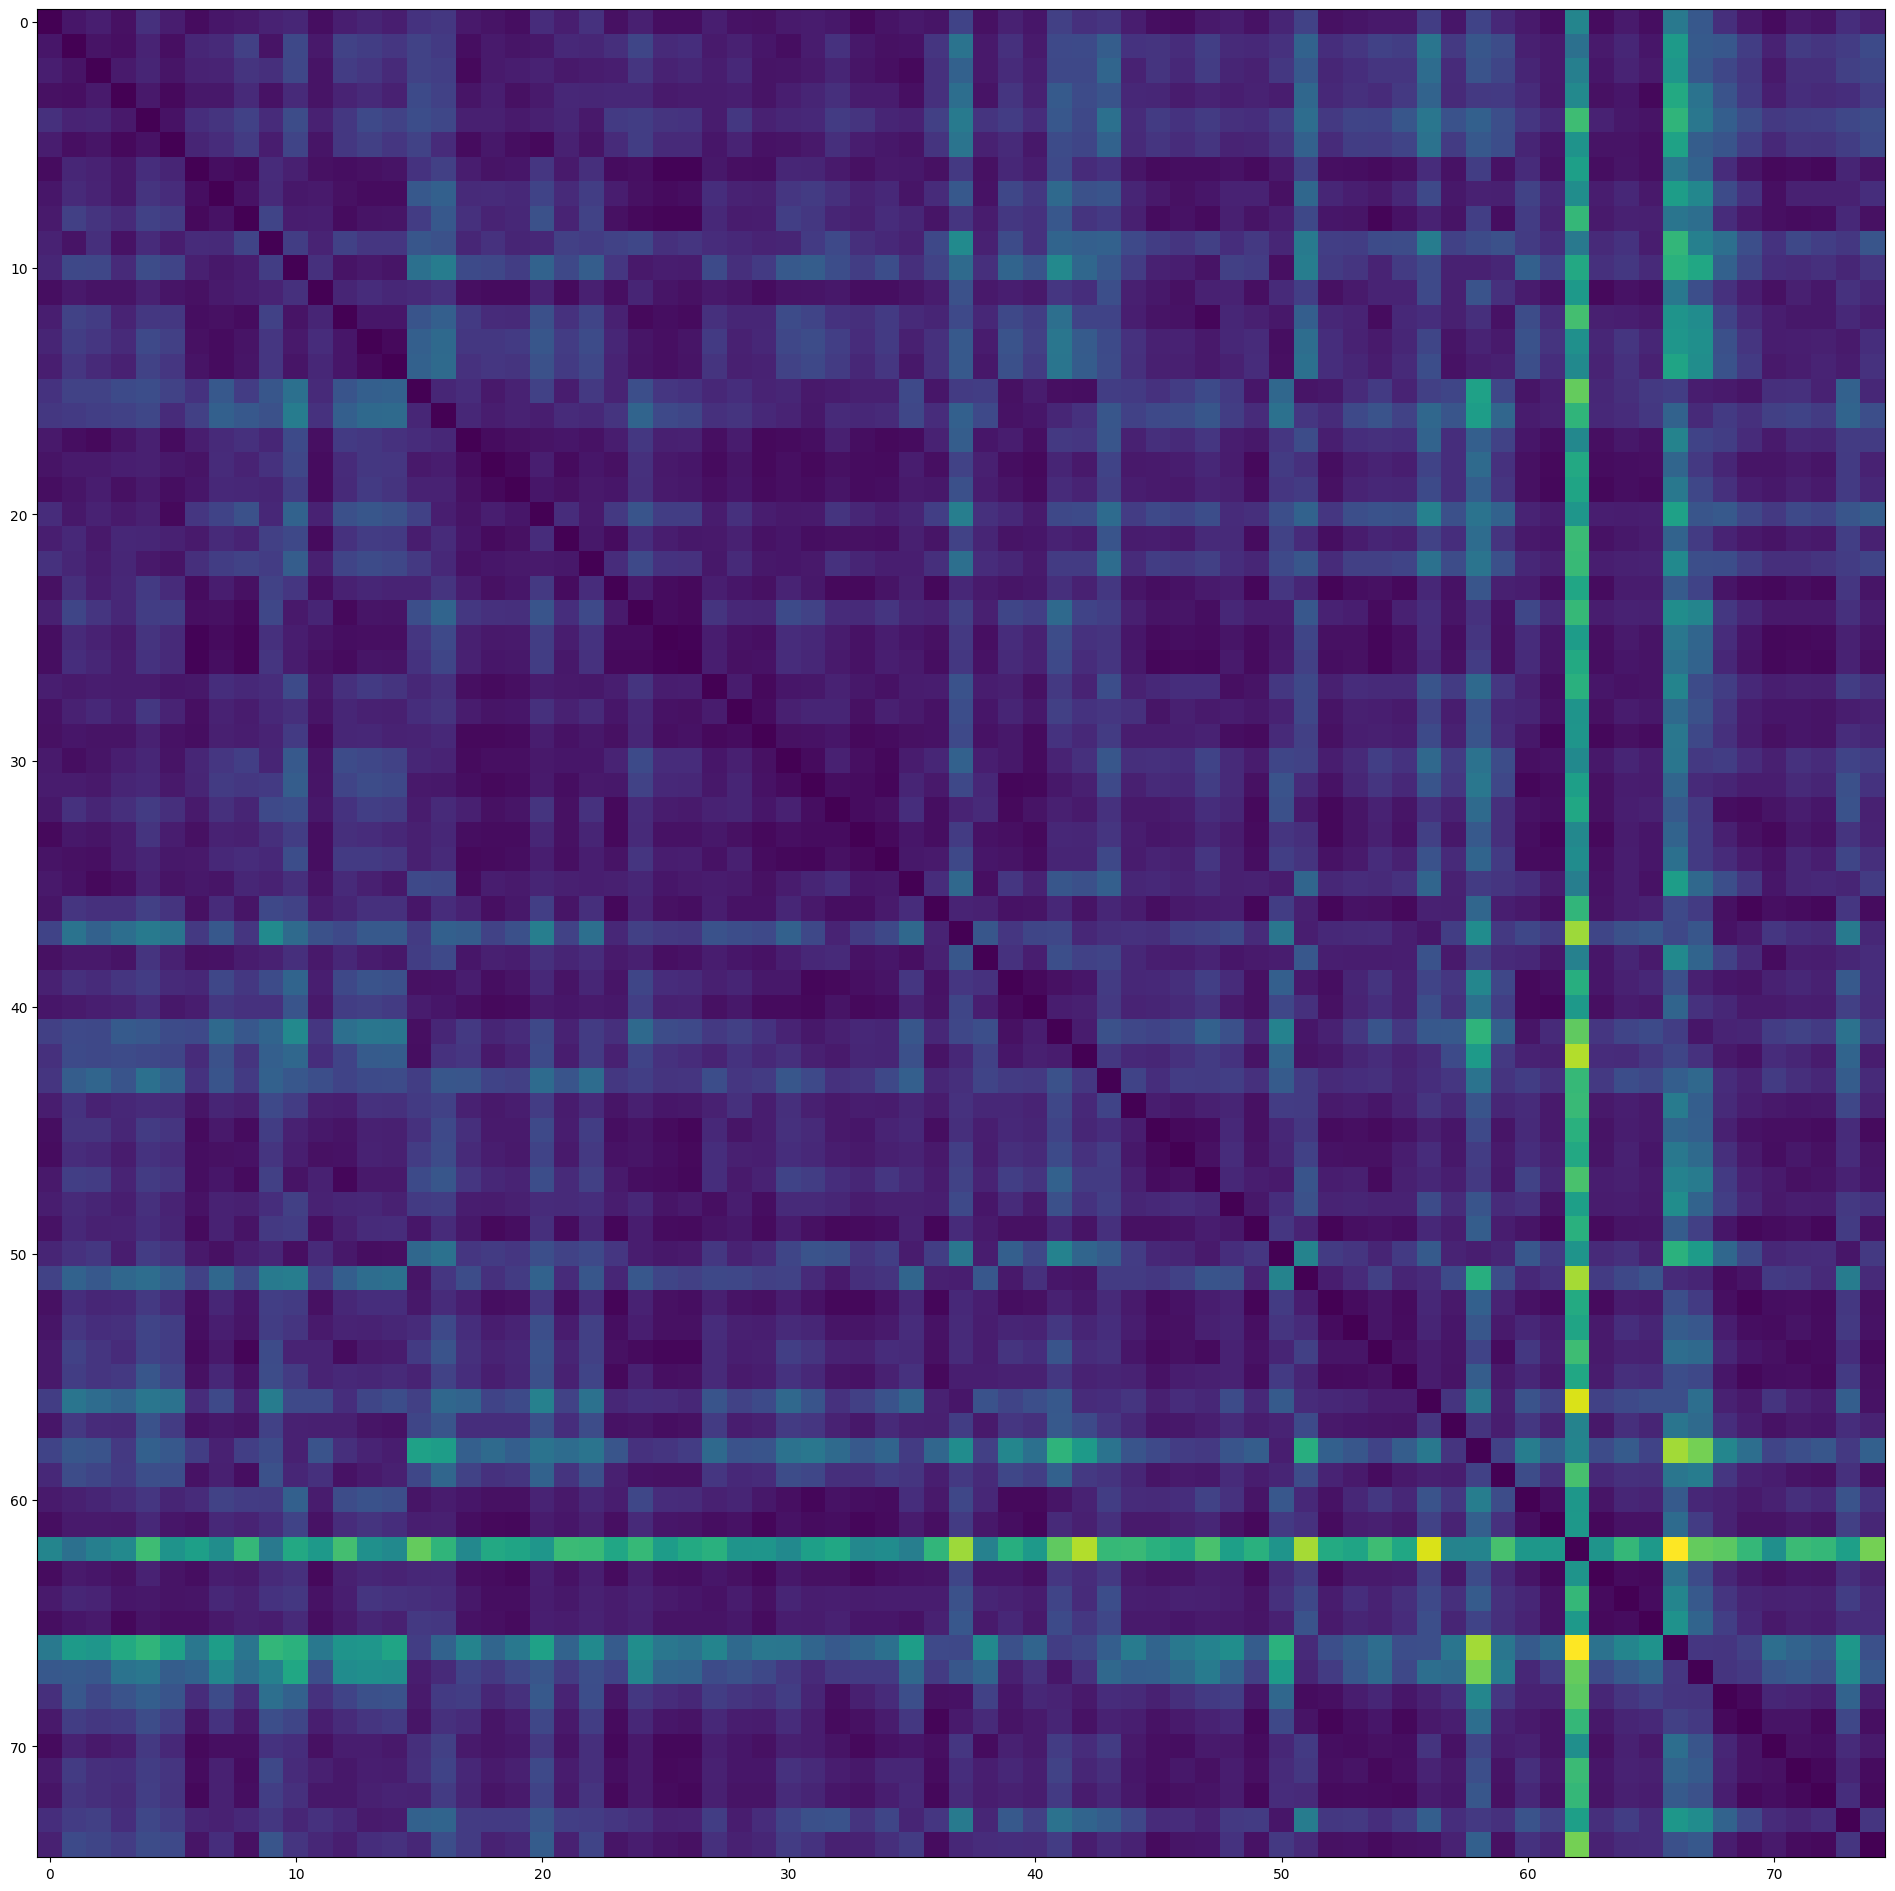

In [11]:
Y_canonical = Y_pred[canonical_ordering_ids]
Y_rsm = cosine_distance(torch.from_numpy(Y_canonical[None]).float(), torch.from_numpy(Y_canonical[:, None]).float())
plt.figure(figsize=(24, 24))
plt.imshow(Y_rsm)

Cosine Distance Visualization for stimulus Data:  
This code calculates cosine distances between stimulus data in the matrix stimulus and displays these distances as an image for visualization and analysis.

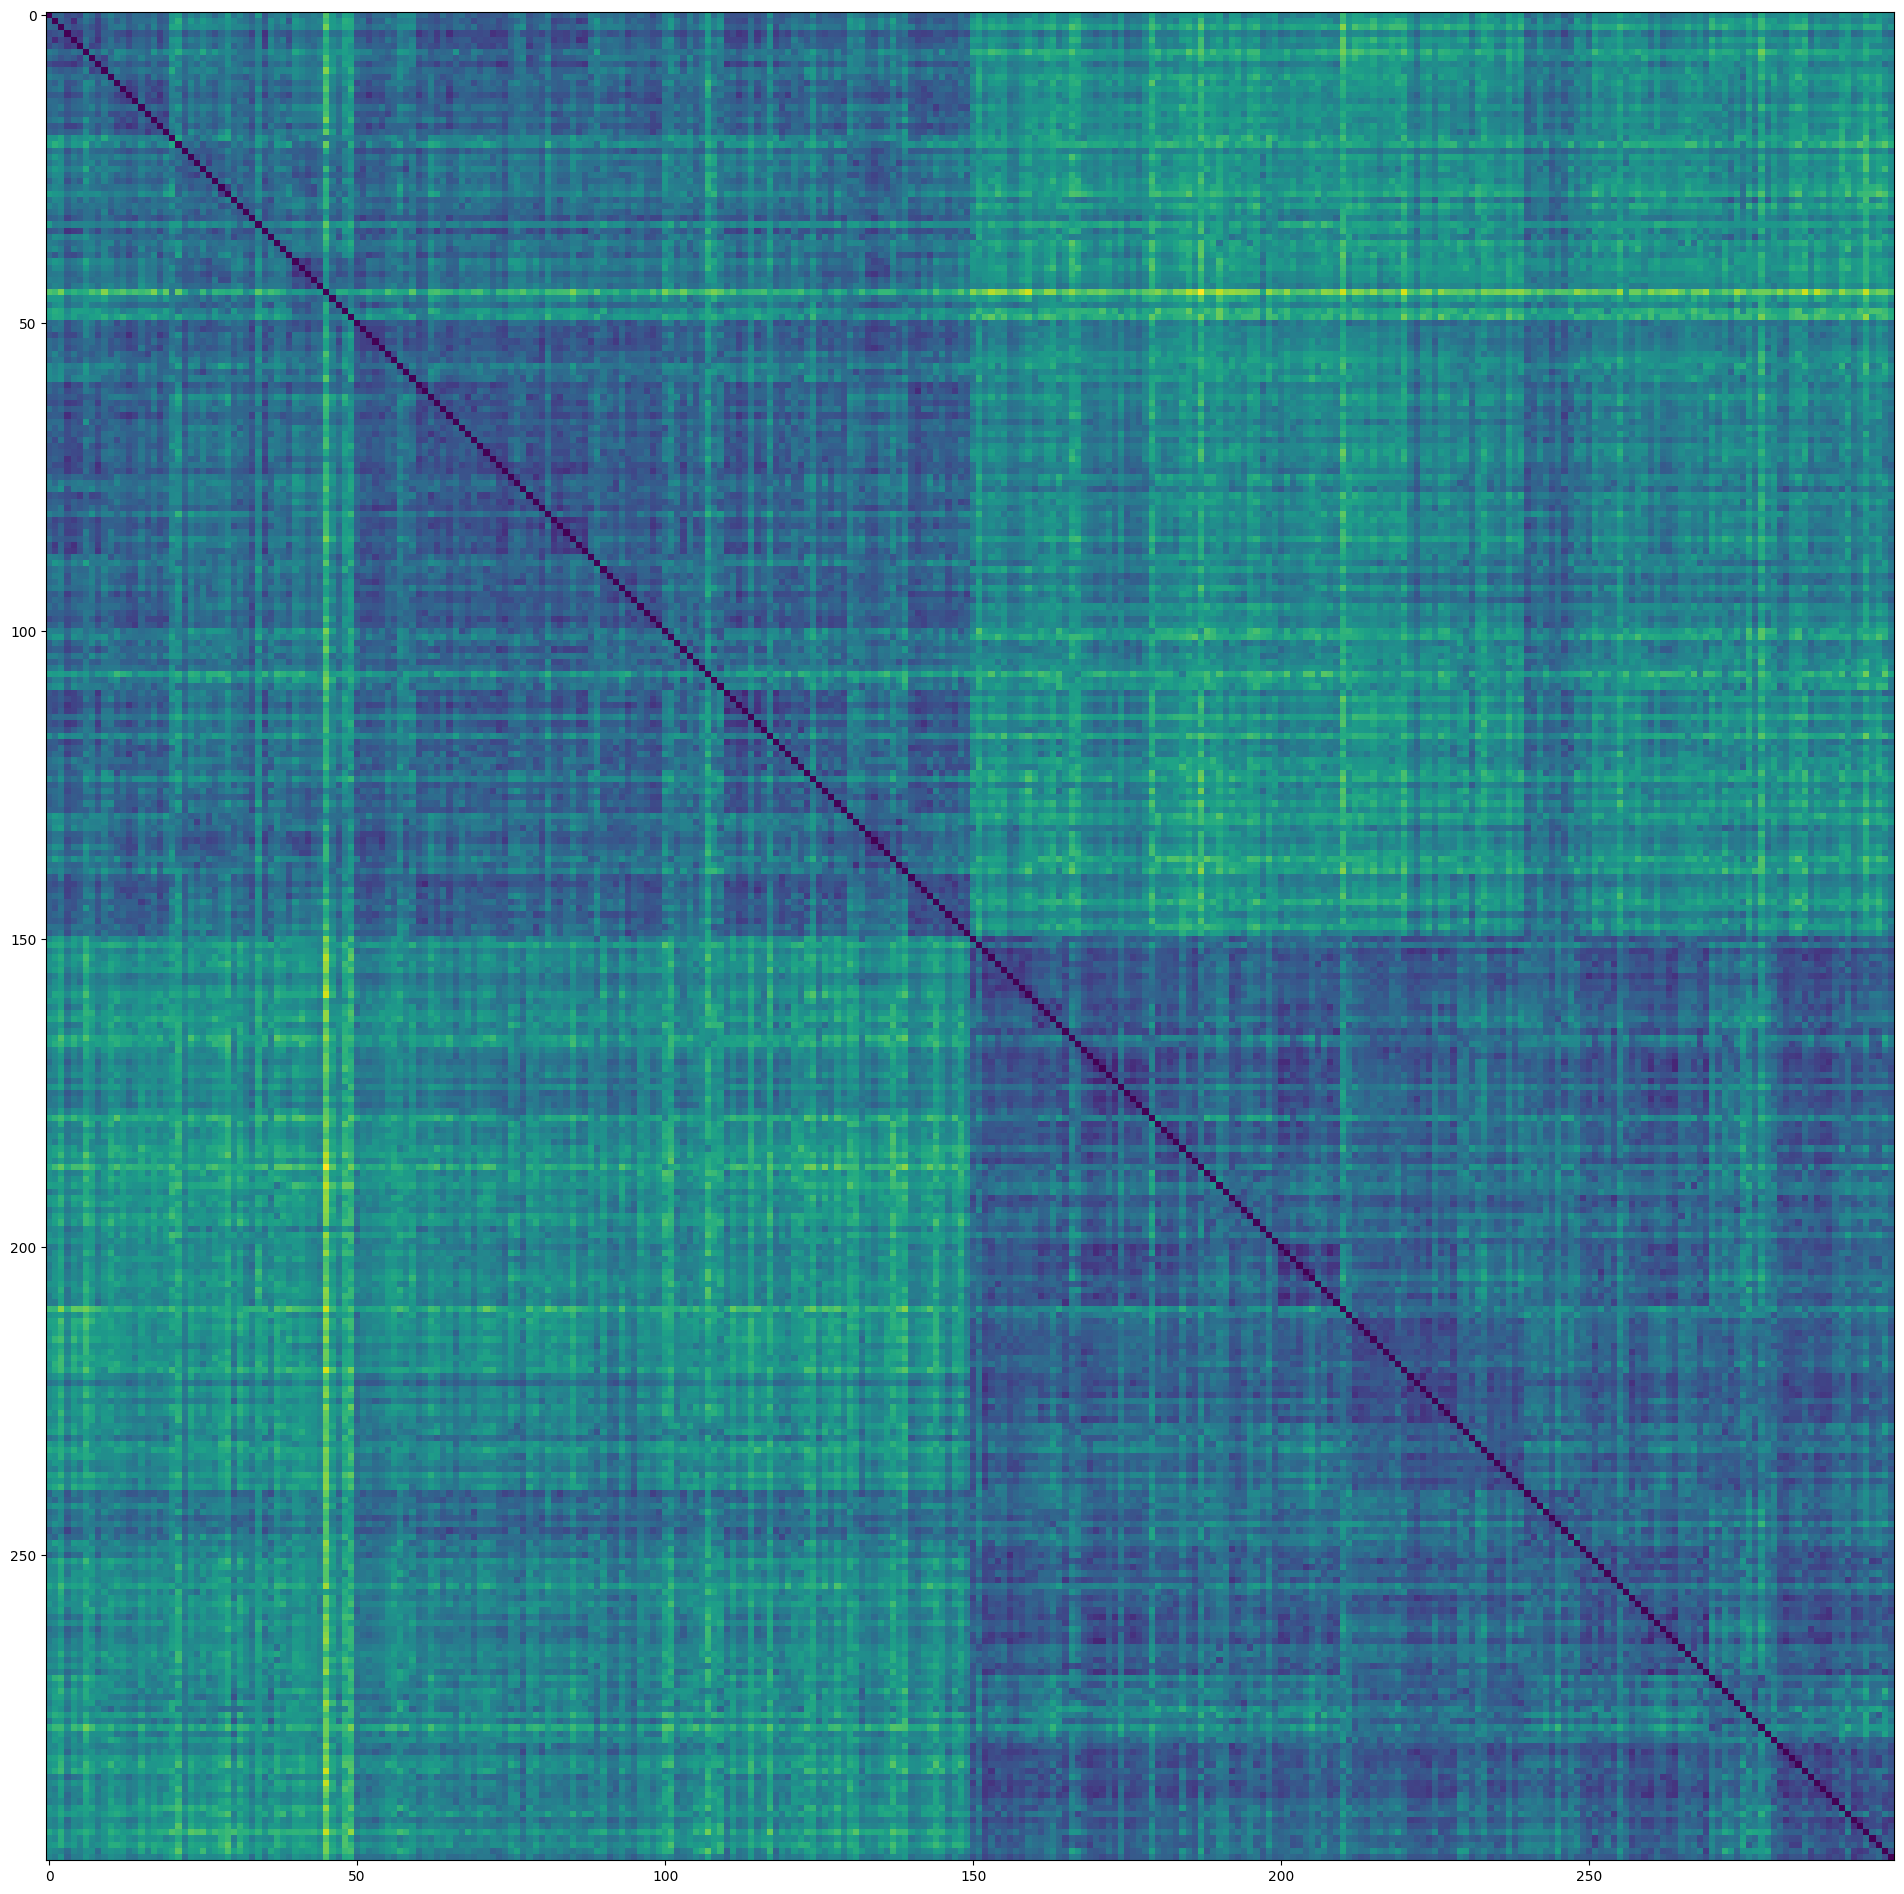

In [12]:
Y_rsm = cosine_distance(torch.from_numpy(stimulus[None]).float(), torch.from_numpy(stimulus[:, None]).float())
plt.figure(figsize=(24, 24))
plt.imshow(Y_rsm)

Computing Accuracy, Standard Dev, etc:  
This code segment performs a series of operations to evaluate the accuracy of a model's predictions for a given subject. It calculates the accuracy and variance of the model's predictions using a cross-validation approach with a range of parameters. The code initializes various variables, including the subject ID and configuration parameters. It then iterates through multiple test runs, using the remaining runs for training the model. For each test run, it loads preprocessed fMRI data, either applies a mask, takes the top voxels, or neither of those, and extracts relevant brain responses. These brain responses are used as input features for a machine learning model to predict clip embeddings. The code evaluates the accuracy of the model's predictions by comparing the cosine distances between the ground truth and predicted embeddings. It computes the accuracy, variance, and other statistics, collecting these values for further analysis. The final output includes the mean accuracy, variance, standard deviation, and minimum and maximum accuracy values across all test runs and subjects. The code aims to assess the model's performance in predicting brain responses to visual stimuli. This code especially can be edited to manipulate results, or to try different tests.  
In the next two code cells the first one calculates all of the values in one run. This can get the different accuracies of the actual data. While the second code cell calculates all of the values over 9 runs (can easily be changed ~ probably increased), with shuffled data. This is to get the random data to compare to, to see whether or not the actual data is giving meaningful results.

In [13]:
def bb_mask(mask, vc_height_min, vc_height_max, vc_width, vc_depth):
    brain_width, brain_depth, brain_height = mask.shape
    vc_center = np.array([brain_width//2, 0, 0])
    vc_bl = vc_center + np.array([-vc_width,0,vc_height_min]) # bottom left
    vc_tr = vc_center + np.array([vc_width,vc_depth,vc_height_max]) # top right
    vc_mask = np.zeros_like(mask)
    vc_mask[vc_bl[0]:vc_tr[0], vc_bl[1]:vc_tr[1], vc_bl[2]:vc_tr[2]] = True # boolean array
    return vc_mask[mask] # flattens both 3D arrays into a one dimensional vector (True values inside the bb, False values outside). Intersection of bb and brain

# subjects = ['sub-05', 'sub-06', 'sub-07']
subject = 'sub-15'
# 6 Runs - 1 run as the test each time (a run is each time the person gets into the scanner and looks into the scanner for a certain amount of time ~ approx 6 mins)
results = dict;

nc_threshold = 25

model_name = 'ViT-B=32'
embedding_name = 'embedding'

# all_runs_total = 0
# all_runs_total_std_dev = 0
# max = 0
# min = 99999
# for subject in subjects:
# for index in range(10):
    # print(subject)
total_accuracy = 0
total_variance = 0
for test_run_id in tqdm(range(6)):
    training_run_ids = list(range(6))
    training_run_ids.remove(test_run_id)

    load_data_params = dict(path = data_path / f'tc2see-v{tc2see_version}-bold-test.hdf5', 
                        subject = subject,
                        tr_offset = 6 / tr,
                        run_normalize='linear_trend',
                        interpolation=False,)

    bold_train, stimulus_ids_train, mask, affine = load_data(
        **load_data_params, # Double astrix to unpack the dictionary
        run_ids = training_run_ids
    )
    vc_mask = bb_mask(mask, 16, 55, 31, 36) # mask, vc_height_min, vc_height_max, vc_width (maxed out), vc_depth (halfway)
    # vc_mask = bb_mask(mask, 16, 50, 23, 30) # mask, vc_height_min, vc_height_max, vc_width (maxed out), vc_depth (halfway)

    bold_test, stimulus_ids_test, _, _ = load_data(
        **load_data_params,
        run_ids = [test_run_id]
    )

    ncsnr = compute_ncsnr(bold_train, stimulus_ids_train) # Compute noise ceiling noise ratio
    nc = compute_nc(ncsnr, num_averages=1)


    nc_vc = nc.copy()
    nc_vc[~vc_mask] = 0 # Set values not in mask to zero
    argsort_ids = np.argsort(-nc_vc) # Default ascending, make descending
    argsort_ids = argsort_ids[:256] # Up to 500 voxels (go about by around powers of 2)

    selection_mask = (nc > nc_threshold) & vc_mask

    print(f'{nc_threshold=}, num_voxels={(nc > nc_threshold).sum()}')
    # X_train = bold_train[:, nc > nc_threshold] # X's are the brain responses (brain numbers in response to images)
    # X_train = bold_train[:, selection_mask] # X's are the brain responses (brain numbers in response to images)  (Within noise ceiling threshold and bounding box)
    X_train = bold_train[:, argsort_ids] # X's are the brain responses (brain numbers in response to images) (With limited voxel amounts)
    X_nan_train = np.isnan(X_train) # Checks if any not a number values in x and sets those to zero
    X_train[X_nan_train] = 0.
    # print(np.sum(X_nan, axis = 1))

    # X_test = bold_test[:, nc > nc_threshold]
    # X_test = bold_test[:, selection_mask]
    X_test = bold_test[:, argsort_ids]
    X_nan_test = np.isnan(X_test) # Checks if any not a number values in x and sets those to zero
    X_test[X_nan_test] = 0.

    with h5py.File(derivatives_path / f'{model_name}-features.hdf5', 'r') as f:
        stimulus = f[embedding_name][:]
    Y_train = stimulus[stimulus_ids_train] # Y's are the clip embeddings of each image (machine learning numbers in response to images)
    Y_test = stimulus[stimulus_ids_test]

    permutation_test = False
    if permutation_test:
        ids = np.arange(Y_train.shape[0])
        np.random.shuffle(ids)
        Y_train = Y_train[ids]

    model = FracRidgeRegressorCV()
    model.fit(X_train, Y_train)
    Y_test_pred = model.predict(X_test) # Y_test and Y_test_pred are n x 512 matrics (n is the number of birds).

    distances = cosine_distance(torch.from_numpy(Y_test[None]).float(), torch.from_numpy(Y_test_pred[:, None]).float()) # Y_test(1, N, 512) & Y_test_pred(N, 1, 512) converted to pytorch arrays from np
    # clip space is 512 dimensional space
    # n is 450
    # cosine_distance grabs the pairwise distance between all of these points (450 x 450 comparisons total), cosine_distance can also be used without broadcasting (compare an nx512 with another nx512 returning an n vector)
    # distances is an (N,N) matrix in the end
    # Each point in the distances represents one of the cosine distances between one of the ground truths and one of the predicted embeddings
    # If we went to row 10 and columns 20 it would be the 10th ground truth versus the 20th predicted embedding
    # cosine_distance - cosine between angle between of two vectors (equal to the dot product of the vectors if they're normalized)
    # X_test heldout data from brain responses
    # Y_test_pred = brain recorded clip embeddings
    # ground truth is the test data we are comparing too (in this case the clip embeddings that come from the test images passed into clip)
    accuracy = round(two_versus_two(distances, stimulus_ids=stimulus_ids).item() * 100, 2) # Chance is 50% (above 50% is good, below not great, if really close ex. 54% or 52%, prove statistically above chance)
    # accuracy2 = round(two_versus_two_slow(distances, stimulus_ids=stimulus_ids) * 100, 2)
    # if accuracy < min:
    #     min = accuracy
    # if accuracy > max:
    #     max = accuracy
    total_accuracy += accuracy

    print(f'{test_run_id=}, {accuracy=}')
    
    variance = np.mean([(accuracy - 66.5917) ** 2])
    total_variance += variance

# all_runs_total += total_accuracy
# variance2 = (total_variance/6)

print("Accuracy", total_accuracy/6)
# all_runs_total_std_dev += np.sqrt(variance2)
# print(all_runs_total_std_dev / 10)
# mean_run = total_accuracy/6
variance = total_variance/6
# print(mean_run)
# # print(variance)
std_dev = np.sqrt(variance)
print("Standard Dev", std_dev)
# all_runs_total += mean_run
# print(all_runs_total/108)
# print(min)
# print(max)
# print(all_runs_total/10)
    

  0%|          | 0/6 [00:00<?, ?it/s]

nc_threshold=25, num_voxels=460
test_run_id=0, accuracy=79.52
nc_threshold=25, num_voxels=477
test_run_id=1, accuracy=68.11
nc_threshold=25, num_voxels=468
test_run_id=2, accuracy=68.04
nc_threshold=25, num_voxels=494
test_run_id=3, accuracy=71.07
nc_threshold=25, num_voxels=507
test_run_id=4, accuracy=58.0
nc_threshold=25, num_voxels=464
test_run_id=5, accuracy=68.04
Accuracy 68.79666666666667
Standard Dev 6.677247453604414


In [14]:
def bb_mask(mask, vc_height_min, vc_height_max, vc_width, vc_depth):
    brain_width, brain_depth, brain_height = mask.shape
    vc_center = np.array([brain_width//2, 0, 0])
    vc_bl = vc_center + np.array([-vc_width,0,vc_height_min]) # bottom left
    vc_tr = vc_center + np.array([vc_width,vc_depth,vc_height_max]) # top right
    vc_mask = np.zeros_like(mask)
    vc_mask[vc_bl[0]:vc_tr[0], vc_bl[1]:vc_tr[1], vc_bl[2]:vc_tr[2]] = True # boolean array
    return vc_mask[mask] # flattens both 3D arrays into a one dimensional vector (True values inside the bb, False values outside). Intersection of bb and brain

# subjects = ['sub-05', 'sub-06', 'sub-07']
subject = 'sub-15'
# 6 Runs - 1 run as the test each time (a run is each time the person gets into the scanner and looks into the scanner for a certain amount of time ~ approx 6 mins)
results = dict;

nc_threshold = 25

model_name = 'ViT-B=32'
embedding_name = 'embedding'

all_runs_total = 0
all_runs_total_variance = 0
all_runs_total_std_dev = 0
max = 0
min = 99999
# for subject in subjects:
for index in tqdm(range(9)):
    # print(subject)
    total_accuracy = 0
    total_variance = 0
    for test_run_id in tqdm(range(6)):
        training_run_ids = list(range(6))
        training_run_ids.remove(test_run_id)

        load_data_params = dict(path = data_path / f'tc2see-v{tc2see_version}-bold-test.hdf5', 
                            subject = subject,
                            tr_offset = 6 / tr,
                            run_normalize='linear_trend',
                            interpolation=False,)

        bold_train, stimulus_ids_train, mask, affine = load_data(
            **load_data_params, # Double astrix to unpack the dictionary
            run_ids = training_run_ids
        )
        vc_mask = bb_mask(mask, 16, 55, 36, 39) # mask, vc_height_min, vc_height_max, vc_width (maxed out), vc_depth (halfway)


        bold_test, stimulus_ids_test, _, _ = load_data(
            **load_data_params,
            run_ids = [test_run_id]
        )

        ncsnr = compute_ncsnr(bold_train, stimulus_ids_train) # Compute noise ceiling noise ratio
        nc = compute_nc(ncsnr, num_averages=1)


        nc_vc = nc.copy()
        nc_vc[~vc_mask] = 0 # Set values not in mask to zero
        argsort_ids = np.argsort(-nc_vc) # Default ascending, make descending
        argsort_ids = argsort_ids[:256] # Up to 500 voxels (go about by around powers of 2)

        selection_mask = (nc > nc_threshold) & vc_mask

        # print(f'{nc_threshold=}, num_voxels={(nc > nc_threshold).sum()}')
        # X_train = bold_train[:, nc > nc_threshold] # X's are the brain responses (brain numbers in response to images)
        # X_train = bold_train[:, selection_mask] # X's are the brain responses (brain numbers in response to images)  (Within noise ceiling threshold and bounding box)
        X_train = bold_train[:, argsort_ids] # X's are the brain responses (brain numbers in response to images) (With limited voxel amounts)
        X_nan_train = np.isnan(X_train) # Checks if any not a number values in x and sets those to zero
        X_train[X_nan_train] = 0.
        # print(np.sum(X_nan, axis = 1))

        # X_test = bold_test[:, nc > nc_threshold]
        # X_test = bold_test[:, selection_mask]
        X_test = bold_test[:, argsort_ids]
        X_nan_test = np.isnan(X_test) # Checks if any not a number values in x and sets those to zero
        X_test[X_nan_test] = 0.

        with h5py.File(derivatives_path / f'{model_name}-features.hdf5', 'r') as f:
            stimulus = f[embedding_name][:]
        Y_train = stimulus[stimulus_ids_train] # Y's are the clip embeddings of each image (machine learning numbers in response to images)
        Y_test = stimulus[stimulus_ids_test]

        permutation_test = True
        if permutation_test:
            ids = np.arange(Y_train.shape[0])
            np.random.shuffle(ids)
            Y_train = Y_train[ids]

        model = FracRidgeRegressorCV()
        model.fit(X_train, Y_train)
        Y_test_pred = model.predict(X_test) # Y_test and Y_test_pred are n x 512 matrics (n is the number of birds).

        distances = cosine_distance(torch.from_numpy(Y_test[None]).float(), torch.from_numpy(Y_test_pred[:, None]).float()) # Y_test(1, N, 512) & Y_test_pred(N, 1, 512) converted to pytorch arrays from np
        # clip space is 512 dimensional space
        # n is 450
        # cosine_distance grabs the pairwise distance between all of these points (450 x 450 comparisons total), cosine_distance can also be used without broadcasting (compare an nx512 with another nx512 returning an n vector)
        # distances is an (N,N) matrix in the end
        # Each point in the distances represents one of the cosine distances between one of the ground truths and one of the predicted embeddings
        # If we went to row 10 and columns 20 it would be the 10th ground truth versus the 20th predicted embedding
        # cosine_distance - cosine between angle between of two vectors (equal to the dot product of the vectors if they're normalized)
        # X_test heldout data from brain responses
        # Y_test_pred = brain recorded clip embeddings
        # ground truth is the test data we are comparing too (in this case the clip embeddings that come from the test images passed into clip)
        accuracy = round(two_versus_two(distances, stimulus_ids=stimulus_ids).item() * 100, 2) # Chance is 50% (above 50% is good, below not great, if really close ex. 54% or 52%, prove statistically above chance)
        # accuracy2 = round(two_versus_two_slow(distances, stimulus_ids=stimulus_ids) * 100, 2)
        if accuracy < min:
            min = accuracy
        if accuracy > max:
            max = accuracy
        total_accuracy += accuracy

        # print(f'{test_run_id=}, {accuracy=}')
        
        variance = np.mean([(accuracy - 50) ** 2])
        # print(np.sqrt(variance))
        total_variance += variance
    all_runs_total += total_accuracy

    # all_runs_total += total_accuracy
    mean_run = total_accuracy/6
    # print("Mean run", mean_run)
    
    # variance2 = total_variance/6
    all_runs_total_variance += total_variance

print("All Runs Total", all_runs_total/54)
# all_runs_total_std_dev += np.sqrt(variance2)
# print(all_runs_total_std_dev / 9)

# print(variance)
std_dev = all_runs_total_variance / 54
all_runs_total_std_dev = np.sqrt(std_dev)
print("Std dev", all_runs_total_std_dev)
    # all_runs_total += mean_run
# print(all_runs_total/108)
print("Min", min)
print("Max", max)
# print(all_runs_total/10)
    

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

All Runs Total 48.38037037037038
Std dev 4.904426194397903
Min 38.19
Max 59.44


Running the code:  
To run all of the code, the only areas that need to be changed in both files is each subjects = [] line. And the subject that the data is to be found for should be included in the square brackets. For example:  
subjects = ['sub-19']  
The code cells should be run in order.  
Path files could be changed to if different.  

The following different lines of these in the Computing Accuracy, Standard Dev, etc. should be commented out, corresponding to each other. The first one is for computing the accuracies without a bounding box mask, the second one is with a bounding box mask, and the third one simply takes the top 256 voxels. (Have only one of the three in each corresponding to each other not commented out when running it).

(1) X_train = bold_train[:, nc > nc_threshold] # X's are the brain responses (brain numbers in response to images)  
(2) X_train = bold_train[:, selection_mask] # X's are the brain responses (brain numbers in response to images)  (Within noise ceiling threshold and bounding box)  
(3) X_train = bold_train[:, argsort_ids] # X's are the brain responses (brain numbers in response to images) (With limited voxel amounts)  

(1)	X_test = bold_test[:, nc > nc_threshold]  
(2)	X_test = bold_test[:, selection_mask]  
(3)	X_test = bold_test[:, argsort_ids]  